# Does Bernie play catch up in the last weeks before a primary vote?

The Michigan primary just ended, with Bernie beating polling averages by over 20%. When I look at the poll charts on <a href='http://elections.huffingtonpost.com/pollster'>Huffington Post Pollster</a>, I feel like Bernie is always playing catch up in each state. I wanted to see if there was a real trend.

I was going to write a few functions to interact with the <a href='http://elections.huffingtonpost.com/pollster/api'>Pollster API</a>, but <a href='https://pypi.python.org/pypi/Pollster'>someone already took care of that</a>!

In [1]:
from pollster import Pollster

pollster = Pollster()

I want to track the dates of primaries and caucuses that have already occurred.

In [2]:
state_dates = {
    'IA': '2016-02-01', 'NH': '2016-02-09', 'NV': '2016-02-20',
    'SC': '2016-02-27', 'KS': '2016-03-05', 'LA': '2016-03-05', 
    'NE': '2016-03-05', 'ME': '2016-03-06', 'MI': '2016-03-08',
    'MS': '2016-03-08'
    }
super_tuesday = ['AL', 'AR', 'CO', 'GA', 'MA', 'MN', 'OK', 'TN',
                 'TX', 'VT', 'VA']
for state in super_tuesday:
    state_dates.update({state: '2016-03-01'})

I need to download all of the state charts that are available.

In [3]:
topic = '2016-president-dem-primary'

state_charts = {state: pollster.charts(state=state, topic=topic)
                for state in state_dates}

http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=NH
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=ME
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=TN
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=CO
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=GA
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=TX
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=LA
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=MN
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=MI
http://elections.huffingtonpost.com/pollster/api/charts?topic=2016-president-dem-primary&state=NE
http://elections.huf

Using those state charts, I need to download all of the rolling poll estimates.

In [4]:
state_estimates = {state: chart[0].estimates_by_date()
                   for state, chart in state_charts.items()
                   if len(chart) > 0}

http://elections.huffingtonpost.com/pollster/api/charts/2016-new-hampshire-presidential-democratic-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-colorado-democratic-presidential-caucus
http://elections.huffingtonpost.com/pollster/api/charts/2016-mississippi-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-texas-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-louisiana-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-minnesota-democratic-presidential-caucus
http://elections.huffingtonpost.com/pollster/api/charts/2016-michigan-presidential-democratic-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-alabama-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-tennessee-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/charts/2016-south-carolina-p

Now, I can write functions to format data for visualization. I want to normalize dates so that we can see how Bernie performs as he gets closer to a primary/caucus date. This is in constrast to using absolute dates, where it's more difficult to compare across states.

In [5]:
from datetime import datetime

import numpy as np


def get_estimate_timeseries(state_estimates, state_dates):
    """
    Iterate through states to get rolling estimates.
    """
    return {state: _get_estimate_timeseries_for_state(
                estimates, state_dates[state])
            for state, estimates in state_estimates.items()
            if len(estimates) > 0}


def _get_estimate_timeseries_for_state(estimates_by_date, voting_date):
    """
    Get a list containing information on days before voting and the percent
    difference between Clinton and Sanders.
    """
    timeseries = [[_get_days_before_voting(estimates['date'], voting_date),
                   _get_estimate_percent_difference(estimates['estimates'])]
                   for estimates in estimates_by_date]
    # Remove any dates that have no comparison data, pop in reverse order
    for idx in reversed(range(len(timeseries))):
        if np.isnan(timeseries[idx][1]):
            timeseries.pop(idx)
    return np.array(timeseries)
    

def _get_days_before_voting(estimate_date, voting_date):
    """
    Get the difference in days between the estimate and voting dates.
    """
    estimate_datetime = datetime.strptime(estimate_date, '%Y-%m-%d')
    voting_datetime = datetime.strptime(voting_date, '%Y-%m-%d')
    return (voting_datetime - estimate_datetime).days


def _get_estimate_percent_difference(estimates):
    """
    Get the difference between Clinton and Sanders support.
    """
    estimate_sanders = [est['value'] for est in estimates
                        if est['choice'] == 'Sanders']
    estimate_clinton = [est['value'] for est in estimates
                        if est['choice'] == 'Clinton']
    # No difference if no comparison is possible, data missing
    if len(estimate_sanders) == 0 or len(estimate_clinton) == 0:
        return np.nan
    return estimate_clinton[0] - estimate_sanders[0]


estimate_timeseries = get_estimate_timeseries(state_estimates, state_dates)

We can visualize these normalized trend lines.

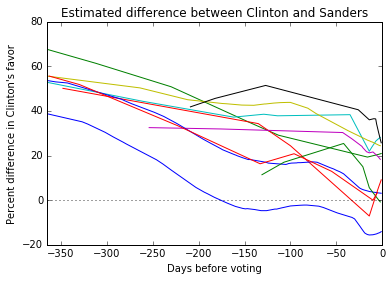

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

# Draw trend lines for each state
for timeseries in estimate_timeseries.values():
    xs = - timeseries[:, 0]
    ys = timeseries[:, 1]
    plt.plot(xs, ys)

# Draw guide line for tied race
plot = plt.plot([-365, 0], [0, 0], ':', color='black', alpha=.75)

plt.title('Estimated difference between Clinton and Sanders')
plt.xlabel('Days before voting')
plt.ylabel('Percent difference in Clinton\'s favor')
plt.xlim([-365, 0])
plt.ylim([-20, 80])
    
plt.show()

It looks like there's a downward trend here, which mirrors what I was seeing at the Pollster website. We know that different states are more or less likely to support Clinton based on demographic trends, so we're seeing variance in the final percent difference in the candidates. What does it look like if we normalize by the last poll estimate?

Note:  One could make the argument that I should be doing something different when normalizing below, perhaps by accounting for the largest difference between Clinton and Sanders in each state, or the maximum support for Clinton in any poll. However, that normalized metric would probably be a little trickier to describe and understand, so I'm just going to keep it simple.

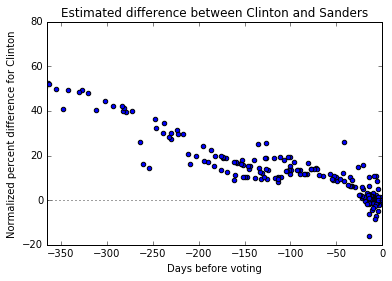

In [7]:
# Draw trend lines for each state
for timeseries in estimate_timeseries.values():
    xs = - timeseries[:, 0]
    ys = timeseries[:, 1] - timeseries[0, 1]
    plt.scatter(xs, ys)

# Draw guide line for tied race
plot = plt.plot([-365, 0], [0, 0], ':', color='black', alpha=.75)

plt.title('Estimated difference between Clinton and Sanders')
plt.xlabel('Days before voting')
plt.ylabel('Normalized percent difference for Clinton')
plt.xlim([-365, 0])
plt.ylim([-20, 80])
    
plt.show()

There are a variety of steps we could take next. I'm pretty sure that what I'm going to do is wrong, but I'll explain why I do it anyway.

Every chart you've seen up to this point has been a plot of Pollster's race estimates. That is, we're visualizing Pollster's models for the Democratic primary race in each state. These models were constructed from poll results in each state, using either LOESS, linear regression, or simple averages. We probably don't want to use these models as a basis for our next step, even though they were useful to show a trend, since the models would need different weights applied to account for differences in the number of polls or variance in the results.

Honestly, I don't know enough about what assumptions are necessary when modeling a time series of polling data. In one sense, the individuals polled at each timestep are independent from one another, in that they are not the same individuals; on the other hand, the publication of polls can have effects on public opinion. One idea that springs to mind would be using an ARMA model to account for both the Clinton and Sanders campaign pouring resources into a state, as well as support propagating through media and social networks.

However, the easiest thing to do seems to be grabbing the raw poll data, aggregating all states, and exploring trends there. It's not perfect, there are probably issues that could be addressed by mixed models to account for state or regional differences, but we'll see where this goes.

I'll access the polls that are associated with each chart.

In [8]:
state_polls = {state: chart[0].polls()
               for state, chart in state_charts.items()
               if len(chart) > 0}

http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-new-hampshire-presidential-democratic-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-colorado-democratic-presidential-caucus
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-mississippi-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-texas-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-louisiana-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-minnesota-democratic-presidential-caucus
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-michigan-presidential-democratic-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-alabama-democratic-presidential-primary
http://elections.huffingtonpost.com/pollster/api/polls?chart=2016-tennessee-democratic-presidential-primary
http://elections.huffingtonpost.

I now want to go through the process of cleaning and formatting the data from these polls. Each poll has a series of questions, and each question has a series of responses. I want to find the questions that are applicable to the Democratic primary, and then find the responses for Clinton and Sanders to find the poll percents.

Note:  while I was exploring the polls, I noticed that several were not labelled correctly as `2016-president-dem-primary`, instead having a value of `none`. In these cases, I need to search the name of the poll to determine if it's for a `Democratic Primary`.

In [9]:
import re


def get_poll_timeseries(state_polls, state_dates):
    """
    Iterate through states to get polling data.
    """
    return {state: _get_poll_timeseries_for_state(
                polls, state_dates[state])
            for state, polls in state_polls.items()
            if len(polls) > 0}


def _get_poll_timeseries_for_state(polls, voting_date):
    """
    Build a poll timeseries for a state, including days before
    voting and the percent difference between Clinton and Sanders.
    """
    questions = _get_democratic_primary_responses_from_polls(polls)
    timeseries = [[_get_days_before_voting(end_date, voting_date),
                   _get_poll_percent_difference(question)]
                  for end_date, question in questions]
    # Remove polls that have no valid comparison
    for idx in reversed(range(len(timeseries))):
        if np.isnan(timeseries[idx][1]):
            timeseries.pop(idx)
    return np.array(timeseries)
    
    
def _get_democratic_primary_responses_from_polls(polls):
    """
    Get the poll questions that are about the Democratic primary,
    rather than the Republican primary or Obama approval ratings.
    """
    questions = []
    for poll in polls:
        for question in poll.questions:
            has_topic = question['topic'] == '2016-president-dem-primary'
            has_name = re.search('Democratic Primary',
                                 question['name']) is not None
            if has_topic or has_name:
                questions.append([poll.end_date, question])
    return questions
    

def _get_poll_percent_difference(question):
    """
    Calculate the difference in poll support between Clinton and
    Sanders.
    """
    responses = question['subpopulations'][0]['responses']
    percent_clinton = [response['value'] for response in responses
                       if response['choice'] == 'Clinton']
    percent_sanders = [response['value'] for response in responses
                       if response['choice'] == 'Sanders']
    if len(percent_clinton) == 0 or len(percent_sanders) == 0:
        return np.nan
    return percent_clinton[0] - percent_sanders[0]


poll_timeseries = get_poll_timeseries(state_polls, state_dates)

I want to normalize these poll differences by the estimated poll average, as we did above. Maybe we'll go a different route eventually, but I just want to see what this looks like.

(-25, 65)

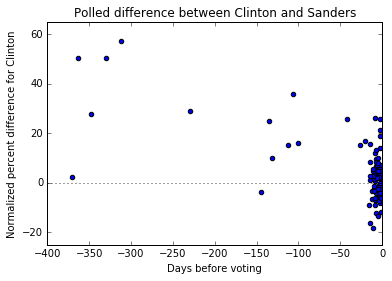

In [10]:
# Normalize poll values basead on final poll estimate
datapoints = []
for state, estimates in estimate_timeseries.items():
    normalize_scalar = estimates[0, 1]
    for poll in poll_timeseries[state]:
        datapoints.append([poll[0], poll[1] - normalize_scalar])
datapoints = np.array(datapoints)

# Create plot
plt.scatter(- datapoints[:, 0], datapoints[:, 1])
plt.plot([-400, 0], [0, 0], ':', color='black', alpha=.75)
plt.title('Polled difference between Clinton and Sanders')
plt.xlabel('Days before voting')
plt.ylabel('Normalized percent difference for Clinton')
plt.xlim([-400, 0])
plt.ylim([-25, 65])

Well, this is a bit disappointing. The Pollster estimate trendlines gave the impression that there was reliable polling data a few months out, but the actual polling data is pretty concentrated at a week or two away from voting. It also looks like the trends are being driven in part by the early outlier; I mean, they're not outliers because they were likely accurate measurements at a point in time when Sanders was less competitive, but I guess the question is whether we would want to build a simple linear model using those points.

Well, I'm already convinced that I'm not going to find the pattern I was looking for, but I might as well fit a simple model since I've come this far. Note that I don't fit this model with an intercept, since I normalize based on the last poll estimate, so there should be no intercept parameter.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     85.87
Date:                Thu, 10 Mar 2016   Prob (F-statistic):           8.75e-15
Time:                        10:45:49   Log-Likelihood:                -345.88
No. Observations:                  92   AIC:                             693.8
Df Residuals:                      91   BIC:                             696.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.1120      0.012     -9.266      0.0

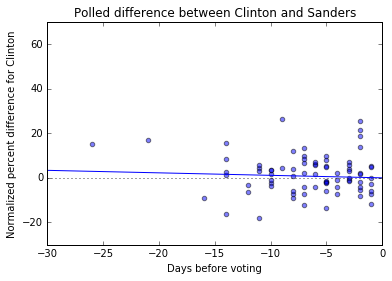

In [11]:
import statsmodels.api as sm

xs = -datapoints[:, 0]
ys = datapoints[:, 1]

# Fit linear model and print results
model = sm.OLS(ys, xs)
results = model.fit()
print results.summary()

# Create plot
coef = results.params
plt.scatter(xs, ys, alpha=.5)
plt.plot([-30, 0], [-30 * coef, 0], color='blue')
plt.plot([-400, 0], [0, 0], ':', color='black', alpha=.75)
plt.title('Polled difference between Clinton and Sanders')
plt.xlabel('Days before voting')
plt.ylabel('Normalized percent difference for Clinton')
plt.xlim([-30, 0])
plt.show()

Yeah, looks like there isn't much of note here. Maybe I could find something more by digging into each state in-depth, but I'm apprehensive about that because most states have a handful of polls, and very few have even ten. I could also weight these datapoints based on pollster reliability, but then I'm pulling in more data and this becomes a larger project. Oh well, you can't win them all. 

What happens if we do a LOWESS fit like Pollster?

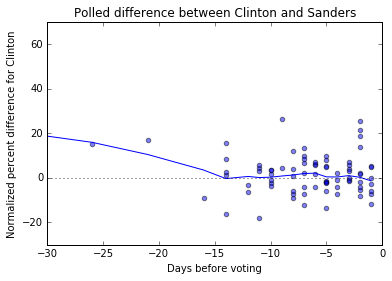

In [12]:
# Fit LOWESS model
model = sm.nonparametric.lowess(ys, xs, frac=1./3)

# Create plot
plt.scatter(xs, ys, alpha=.5)
plt.plot(model[:, 0], model[:, 1])
plt.plot([-400, 0], [0, 0], ':', color='black', alpha=.75)
plt.title('Polled difference between Clinton and Sanders')
plt.xlabel('Days before voting')
plt.ylabel('Normalized percent difference for Clinton')
plt.xlim([-30, 0])
plt.show()

Sure enough, we get a stronger trendline up until two weeks before voting occurs. Not shown: the LOWESS fit tracking the early outliers, which makes the trend seem more impressive.